In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

# show all columns
pd.options.display.max_columns = None

In [ ]:
# fill NA values in Spatially enabled dataframes (ignores SHAPE column)
def fill_na_sedf(df_with_shape_column, fill_value=0):
    if 'SHAPE' in list(df_with_shape_column.columns):
        df = df_with_shape_column.copy()
        shape_column = df['SHAPE'].copy()
        del df['SHAPE']
        return df.fillna(fill_value).merge(shape_column,left_index=True, right_index=True, how='inner')
    else:
        raise Exception("Dataframe does not include 'SHAPE' column")

In [9]:
outputs = '.\\Outputs'

if not os.path.exists(outputs):
    os.makedirs(outputs)
    
spatialRef    = 26912 #NAD_1983_UTM_Zone_12N

# create bus lines

In [88]:
transit_links = r".\Inputs\TransitLinks.dbf"
tl_df = gpd.read_file(transit_links)
tl_df = tl_df[tl_df['MODE'] == 4].copy()

tl_df['LINKID'] = tl_df['A'].astype(str) + '_' + tl_df['B'].astype(str)
del tl_df['A']
del tl_df['B']
del tl_df['geometry']

linkview = gpd.read_file(r".\Inputs\v832_SE50_Net50_Link.shp")
linkview_columns = list(linkview.columns)
linkview = linkview.merge(tl_df, on='LINKID', how='inner')
linkview = linkview[linkview['FT']< 12].copy()
linkview = linkview[linkview_columns].copy()
linkview = linkview.set_crs(spatialRef)

# create bus stops


In [ ]:
transit_links = r".\Inputs\TransitLinks.dbf"
tl_df = gpd.read_file(transit_links)
tl_df = tl_df[(tl_df['MODE'] > 4) & tl_df['MODE'] <= 9].copy()

stop_a_max = tl_df.groupby('A', as_index=False)['STOPA'].max()
stop_b_max = tl_df.groupby('B', as_index=False)['STOPB'].max()

stop_a_max.rename({'STOPA':'MAX_STOPA'}, axis=1, inplace=True)
stop_b_max.rename({'STOPB':'MAX_STOPB'}, axis=1, inplace=True)

nodes = r".\Inputs\v832_SE50_Net50_Node.shp"
nodes_df = gpd.read_file(nodes)
fieldnames = nodes_df.columns

if "TranStop" in fieldnames:
    print("TranStop field already exists in Node shapefile. Overwriting data...\n")
else:
    nodes_df['TranStop'] = np.nan

nodes_df = nodes_df.merge(stop_a_max, left_on='N', right_on='A', how='inner')
nodes_df = nodes_df.merge(stop_b_max, left_on='N', right_on='B', how='inner')

nodes_df.loc[nodes_df['MAX_STOPA'] > 0 ,'TranStop'] = 1
nodes_df.loc[nodes_df['MAX_STOPA'] <= 0 ,'TranStop'] = 0
nodes_df.loc[nodes_df['MAX_STOPB'] > 0 ,'TranStop'] = 1
nodes_df.loc[nodes_df['MAX_STOPB'] <= 0 ,'TranStop'] = 0




nodes_df = nodes_df[nodes_df['TranStop'] == 1].copy()
nodes_df = nodes_df.set_crs(spatialRef)

# zeroFields

In [ ]:
fieldlist = ["TAZAREA", "LOCALAREA", "STOPSAREA", "LOCALPCT", "STOPSPCT", "WALKPCT"]
taz = r"E:\Projects\Replace-Arcpy-In-TDM\Create Walk Buffer\Inputs\TAZ.dbf"
# taz = r"E:\Projects\Replace-Arcpy-In-TDM\Create Walk Buffer\Inputs\TAZ.shp"
taz_df = gpd.read_file(taz)
taz_fields = list(taz_df.columns)
for field in fieldlist:
        if field not in taz_fields:
                taz_df[field] = 0

taz_df['TAZAREA'] = taz_df['geometry'].area # works as long as taz is in utm
# taz_df.head()

# updateLinesArea


In [89]:
lbl_buffer = linkview.drop(['TAZID'], axis=1)
meters_to_buffer =  .4 * 1609.344 # 4-mile buffer
# lbl_buffer = local_bus_lines.buffer(meters_to_buffer, join_style=2)
lbl_buffer['geometry'] = lbl_buffer['geometry'].buffer(meters_to_buffer, join_style=2)
lbl_buffer = lbl_buffer.dissolve()
taz = r".\Inputs\TAZ.dbf"
taz_df = gpd.read_file(taz)

BusLines_TAZ_Intersect = lbl_buffer.overlay(taz_df, how='intersection')
BusLines_Dissolve = BusLines_TAZ_Intersect.dissolve(by='TAZID')

BusLines_Dissolve['F_AREA'] = BusLines_Dissolve['geometry'].area

BusStops_StatsArea = BusLines_Dissolve.groupby('TAZID')[['F_AREA']].max().reset_index()
BusStops_StatsArea.rename({'F_AREA':'MAX_F_AREA'}, axis=1, inplace=True)

taz_df_stops = taz_df.merge(BusStops_StatsArea.reset_index(), left_on='TAZID', right_on='TAZID', how='left')

taz_df_stops.loc[taz_df_stops['MAX_F_AREA'] > 0 ,'LOCALAREA'] = taz_df_stops['MAX_F_AREA']
taz_df_stops.loc[taz_df_stops['MAX_F_AREA'] <= 0 ,'LOCALAREA'] = taz_df_stops['LOCALAREA']




# gpd.to_file()
# gpd.to_file()
# gpd.to_file()
# gpd.to_file()


<AxesSubplot:>

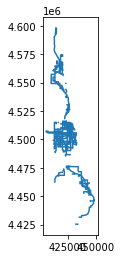

In [81]:
gpd.read_file(r".\Expected_Outputs\wb_elseBusLines_Buffer.shp").plot()

In [92]:
gpd.read_file(r".\Expected_Outputs\wb_BusLines_Dissolve.shp")

,TAZID,geometry
0,12,"POLYGON ((414101.020 4598059.718, 414090.923 4..."
1,13,"POLYGON ((415301.498 4598637.190, 415298.386 4..."
2,30,"POLYGON ((414103.689 4597275.205, 414102.352 4..."
3,31,"POLYGON ((414101.857 4596616.997, 414100.104 4..."
4,32,"POLYGON ((414101.857 4596616.997, 414100.437 4..."
...,...,...
1904,2850,"POLYGON ((432407.878 4425999.665, 432407.850 4..."
1905,2851,"POLYGON ((432956.757 4425982.392, 432954.880 4..."
1906,2870,"POLYGON ((444240.645 4450507.326, 444228.538 4..."
1907,2871,"POLYGON ((417027.995 4467412.550, 417060.666 4..."


In [51]:
gpd.read_file(r".\Expected_Outputs\wb_BusStops_Dissolve.shp").head()

,TAZID,geometry
0,279,"POLYGON ((413269.011 4560728.195, 413252.822 4..."
1,280,"POLYGON ((412980.997 4560439.906, 412958.510 4..."
2,281,"POLYGON ((413440.258 4560441.148, 413436.187 4..."
3,282,"POLYGON ((413440.258 4560441.148, 413445.959 4..."
4,283,"POLYGON ((412957.414 4559637.105, 412936.461 4..."


In [57]:
gpd.read_file(r".\Expected_Outputs\wb_BusStops_Area.shp")

,TAZID,F_AREA,geometry
0,279,355840.808499,"POLYGON ((413269.011 4560728.195, 413252.822 4..."
1,280,357542.355256,"POLYGON ((412980.997 4560439.906, 412958.510 4..."
2,281,71176.085782,"POLYGON ((413440.258 4560441.148, 413436.187 4..."
3,282,513689.509555,"POLYGON ((413440.258 4560441.148, 413445.959 4..."
4,283,3623.672990,"POLYGON ((412957.414 4559637.105, 412936.461 4..."
...,...,...,...
629,2471,408322.674550,"POLYGON ((444474.709 4452361.276, 444474.480 4..."
630,2472,373112.875021,"POLYGON ((444874.942 4451105.692, 444800.402 4..."
631,2478,399289.570451,"POLYGON ((444413.890 4451749.900, 444426.072 4..."
632,2479,417582.306507,"POLYGON ((444515.422 4451111.490, 444530.722 4..."


In [94]:
linkview.to_file(os.path.join(outputs, 'links.shp'))